## Setup Environment

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/D2

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/D2


## Load Dataset

In [ ]:
import pandas as pd

# File path to your CSV
file_path = '/content/drive/MyDrive/D2/merge.csv'

# Read the file with pandas
try:
    df = pd.read_csv(file_path)
    print(df.head())  # Display the first few rows of the dataframe to inspect
except Exception as e:
    print(f"Error reading CSV: {e}")
print(df.shape)

   label                                          statement
0      1  I investigated Abramoff and people ended up in...
1      0  Takes credit for reining in state spending whe...
2      0  Most of your serial killers, most of your peop...
3      0  Says Hillary Clinton wants to essentially abol...
4      0  The first round of stimulus ... it created zer...
(8057, 2)


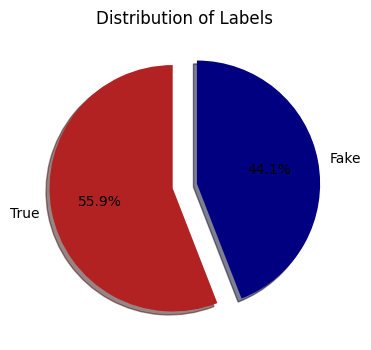

In [ ]:
import matplotlib.pyplot as plt

# Checking if our data is well balanced
label_size = [df['label'].sum(), len(df['label']) - df['label'].sum()]

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(label_size,
        explode=[0.1, 0.1],
        colors=['firebrick', 'navy'],
        startangle=90,
        shadow=True,
        labels=['True', 'Fake'],
        autopct='%1.1f%%')

plt.title('Distribution of Labels')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Separate features and target
X = df['statement']
y = df['label']

# Convert text data to numerical data (e.g., using TF-IDF)
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Convert resampled data back to a DataFrame
df_balanced = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
df_balanced['label'] = y_resampled

# Display new class counts
print(df_balanced['label'].value_counts())


label
1    4504
0    4504
Name: count, dtype: int64


# Train-test-split

In [ ]:
from sklearn.model_selection import train_test_split

# Train-Validation-Test split into 70:15:15 ratio
train_text, temp_text, train_labels, temp_labels = train_test_split(df['statement'], df['label'],
                                                                    test_size=0.3,  # 30% for temp_text
                                                                    random_state=2018,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                test_size=0.5,  # 50% of temp_text for test_text
                                                                random_state=2018,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

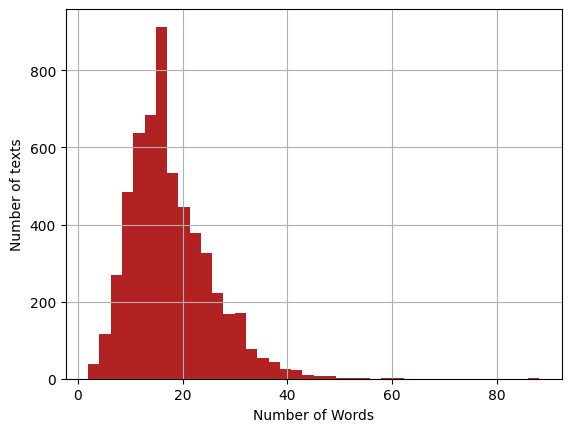

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# Sample data
sample_data = ["Build fake news model.", "Using BERT."]

# Encode text
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding=True, truncation=True, return_tensors='pt')

# Print the tokenized sample data
print(tokenized_sample_data)


{'input_ids': tensor([[  101,  3857,  8275,  2739,  2944,  1012,   102],
        [  101,  2478, 14324,  1012,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0]])}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 25

### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels.long())                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(val_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

In [ ]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        sent_id, mask, labels = [r.to(device) for r in batch]  # Push the batch to the device (CPU or GPU)
        labels = labels.long()  # Convert labels to Long data type
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        sent_id, mask, labels = [t.to(device) for t in batch]
        labels = labels.long()  # Convert labels to Long data type
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss


### Model training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function
criterion = nn.CrossEntropyLoss() # Define the loss function

# Train and predict
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\nEpoch {:3d}/{:3d}'.format(epoch + 1, epochs))

    # Move model to the GPU
    model.to(device)

    # Set model to training mode
    model.train()

    train_loss = 0.0
    for batch in train_dataloader:  # Iterate over batches
        # Unpack the batch according to how your dataloader is set up
        # For example, if your dataloader returns input_ids, attention_masks, labels:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)  # Move inputs and targets to GPU
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(input_ids, attention_masks)  # Forward pass, adjust based on your model's input
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        train_loss += loss.item() * input_ids.size(0)

    # Set model to evaluation mode
    model.eval()

    valid_loss = 0.0
    with torch.no_grad():
        # Make sure you have defined 'val_dataloader' and use it here
        for input_ids, attention_masks, labels in val_dataloader:  # Unpack all three values from val_dataloader
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)  # Move inputs and targets to GPU
            outputs = model(input_ids, attention_masks)  # Forward pass, include attention masks
            loss = criterion(outputs, labels)  # Calculate the loss
            valid_loss += loss.item() * input_ids.size(0)  # Update the validation loss

    train_loss = train_loss / len(train_dataloader.dataset)  # Calculate average training loss
    valid_loss = valid_loss / len(val_dataloader.dataset)  # Calculate average validation loss

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')


Epoch   1/ 25
Training Loss: 0.688
Validation Loss: 0.687

Epoch   2/ 25
Training Loss: 0.686
Validation Loss: 0.687

Epoch   3/ 25
Training Loss: 0.684
Validation Loss: 0.685

Epoch   4/ 25
Training Loss: 0.684
Validation Loss: 0.682

Epoch   5/ 25
Training Loss: 0.683
Validation Loss: 0.680

Epoch   6/ 25
Training Loss: 0.681
Validation Loss: 0.681

Epoch   7/ 25
Training Loss: 0.681
Validation Loss: 0.679

Epoch   8/ 25
Training Loss: 0.680
Validation Loss: 0.678

Epoch   9/ 25
Training Loss: 0.679
Validation Loss: 0.676

Epoch  10/ 25
Training Loss: 0.679
Validation Loss: 0.675

Epoch  11/ 25
Training Loss: 0.677
Validation Loss: 0.675

Epoch  12/ 25
Training Loss: 0.677
Validation Loss: 0.673

Epoch  13/ 25
Training Loss: 0.675
Validation Loss: 0.673

Epoch  14/ 25
Training Loss: 0.675
Validation Loss: 0.671

Epoch  15/ 25
Training Loss: 0.674
Validation Loss: 0.671

Epoch  16/ 25
Training Loss: 0.674
Validation Loss: 0.670

Epoch  17/ 25
Training Loss: 0.673
Validation Loss: 0.6

### Model performance

In [ ]:
# load weights of best model
#path = 'c1_fakenews_weights.pt'
#model.load_state_dict(torch.load(path))

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader

# Define your BERT-based architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
# Create an instance of your architecture
model = BERT_Arch(bert_model)

# Load weights of the best model
path = 'c2_new_model_weights.pt'
state_dict = torch.load(path)
# Load the modified state dictionary
model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.25      0.36       533
           1       0.60      0.88      0.71       676

    accuracy                           0.61      1209
   macro avg       0.62      0.57      0.54      1209
weighted avg       0.61      0.61      0.56      1209



In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertModel, BertTokenizer
import torch.nn as nn

# Define your BERT-based architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
# Create an instance of your architecture
model = BERT_Arch(bert_model)

# Load weights of the best model
path = 'c2_new_model_weights.pt'
state_dict = torch.load(path)
# Load the modified state dictionary
model.load_state_dict(state_dict, strict=False)

# Assuming test_seq, test_mask, and test_labels are already prepared
test_seq = torch.tensor(test_seq)  # Convert to tensor if not already
test_mask = torch.tensor(test_mask)  # Convert to tensor if not already

# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(test_seq, test_mask)
    _, preds = torch.max(outputs, dim=1)

# Convert predictions and true labels to numpy arrays
preds_np = preds.detach().cpu().numpy()
test_labels_np = np.array(test_labels)

# Calculate accuracy
accuracy = accuracy_score(test_labels_np, preds_np)
print(f"Accuracy: {accuracy:.3f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_np, preds_np)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate True Positives, False Positives, False Negatives for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1-score for each class
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate macro-averaged precision, recall, F1-score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

# Calculate weighted-averaged precision, recall, F1-score
support = np.sum(conf_matrix, axis=1)  # Number of true instances for each class
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1_score = np.sum(f1_score * support) / np.sum(support)

# Print results
print("\nPrecision, Recall, F1-score for each class:")
for i in range(len(precision)):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

print("\nMacro-averaged metrics:")
print(f"Macro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall: {macro_recall:.3f}")
print(f"Macro-averaged F1-score: {macro_f1_score:.3f}")

print("\nWeighted-averaged metrics:")
print(f"Weighted-averaged Precision: {weighted_precision:.3f}")
print(f"Weighted-averaged Recall: {weighted_recall:.3f}")
print(f"Weighted-averaged F1-score: {weighted_f1_score:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels_np, preds_np))

Accuracy: 0.600
Confusion Matrix:
[[129 404]
 [ 80 596]]

Precision, Recall, F1-score for each class:
Class 0:
  Precision: 0.617
  Recall: 0.242
  F1-score: 0.348
Class 1:
  Precision: 0.596
  Recall: 0.882
  F1-score: 0.711

Macro-averaged metrics:
Macro-averaged Precision: 0.607
Macro-averaged Recall: 0.562
Macro-averaged F1-score: 0.529

Weighted-averaged metrics:
Weighted-averaged Precision: 0.605
Weighted-averaged Recall: 0.600
Weighted-averaged F1-score: 0.551

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.24      0.35       533
           1       0.60      0.88      0.71       676

    accuracy                           0.60      1209
   macro avg       0.61      0.56      0.53      1209
weighted avg       0.61      0.60      0.55      1209



## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# testing on unseen data
unseen_news_text = [

                    "Takes credit for reining in state spending when he was governor.",               # 0
                    "Most of your serial killers, most of your people who commit domestic violence, they start off by abusing animals.",           # 0
                    "Says Hillary Clinton wants to essentially abolish the Second Amendment.",                        # 0
                    "The first round of stimulus ... it created zero jobs.", #0
                    "Says MarcoRubio voted to slash school funding by billions of dollars and would eliminate the Department of Education.", #1
                    "Says Hillary Clintons rejection of efforts to make it easier to vote and harder to cheat not only defies logic, but the will of the majority of Americans.", #1
                   ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 0, 0, 1, 1, 1])

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Path to save the model
model_save_path = '/content/drive/MyDrive/Project11_FakeNewsDetection/bert_model.pth'

# Save the state dictionary
torch.save(model.state_dict(), model_save_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertForSequenceClassification

# Define the model name or path
model_name = 'bert-base-uncased'

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(model_name)

# Define the directory path to save the model
model_dir = 'bert_model/'

# Save the model's architecture and weights to the specified directory
model.save_pretrained(model_dir)

# The model's architecture and weights are now saved in the specified directory

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Streamlit


In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
!wget -q -O - http://ipv4.icanhazip.com

34.168.57.120


In [ ]:
import pickle
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [ ]:
# Define the BERT_Arch class
class BERT_Arch:
    def __init__(self, param1, param2):
        # Constructor for the class
        self.param1 = param1
        self.param2 = param2

    def some_method(self):
        # Example method
        return self.param1 + self.param2

# Load the model
with open('/content/model_save', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Load a pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoModelForSequenceClassification

# Define the model architecture
# This assumes the model is a sequence classification model from Hugging Face transformers
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
import pickle

# Step 1: Define the model architecture
# Replace 'bert-base-uncased' with the specific model architecture you are using
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

# Step 2: Specify the file path to the state dictionary file
path = '/content/model_save'  # Replace with the correct file path

# Step 3: Load the state dictionary from the file
state_dict = torch.load("/content/drive/MyDrive/Project11_FakeNewsDetection/c2_new_model_weights.pt")

# Step 4: Handle unexpected keys in the state dictionary
# Define a list of unexpected keys (as per your error message)
unexpected_keys = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias"]

# Remove unexpected keys from the state dictionary
for key in unexpected_keys:
    if key in state_dict:
        del state_dict[key]

# Step 5: Load the state dictionary into the model
# Set strict=False to ignore missing or unexpected keys
model.load_state_dict(state_dict, strict=False)

# Optional: Move the model to the desired device (e.g., GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# At this point, the model is loaded and ready for use


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Load the pre-trained BERT model for sequence classification
model_name = 'bert-base-uncased'  # Replace with your specific model if different
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.eval()  # Set the model to evaluation mode

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Unseen news text data
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",  # Fake
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",  # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",  # True
    "Trump administration issues new rules on U.S. visa waivers", # True
    "Trump urges Moore to concede Alabama Senate race" #True
]

# Tokenize and encode sequences in the test set
MAX_LENGTH = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Get the input tensors
input_ids = tokens_unseen['input_ids']
attention_mask = tokens_unseen['attention_mask']

# Make predictions
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    logits = outputs.logits

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Get the predicted classes
predicted_classes = torch.argmax(probabilities, dim=1)

# Print the input headlines and their predicted classes
for i, headline in enumerate(unseen_news_text):
    print(f"Headline: {headline}")
    print(f"Predicted class: {predicted_classes[i].item()}")  # Prints the predicted class (0 or 1)
    print(f"Probabilities: {probabilities[i]}\n")  # Prints the predicted probabilities for each class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Headline: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Predicted class: 1
Probabilities: tensor([0.2317, 0.7683])

Headline: WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy
Predicted class: 1
Probabilities: tensor([0.1843, 0.8157])

Headline: U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources
Predicted class: 1
Probabilities: tensor([0.2078, 0.7922])

Headline: Trump administration issues new rules on U.S. visa waivers
Predicted class: 1
Probabilities: tensor([0.1557, 0.8443])

Headline: Trump urges Moore to concede Alabama Senate race
Predicted class: 1
Probabilities: tensor([0.3780, 0.6220])

